# Melanoma Detection Assignment

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.6.4


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
data_dir = "/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration"

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(os.path.join(data_dir, "Train"))
data_dir_test = pathlib.Path(os.path.join(data_dir, "Test"))

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               seed=123, 
                                                               validation_split=0.2, 
                                                               subset = "training",
                                                               label_mode='categorical',
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size
                                                              )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2023-01-17 22:50:11.884245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 22:50:11.885269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 22:50:12.129447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 22:50:12.130371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 22:50:12.131255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2, 
                                                             subset = "validation",
                                                             label_mode='categorical',
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size
                                                            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [10]:
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

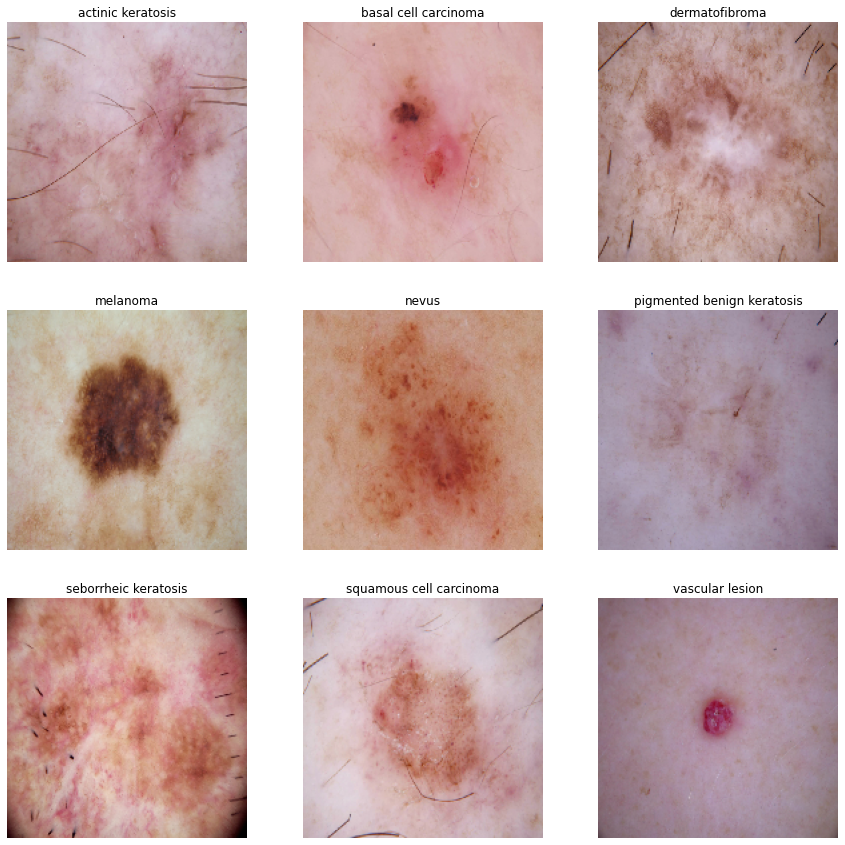

In [11]:
### your code goes here, you can use training or validation data to visualize

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here

def create_basic_model():
    # Initilize a Sequential model object
    model = Sequential()

    #Normalize the pixel values between (0,1)
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

    #First Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Second Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Third Convolution layer
    model.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Dropout layer with 50% of the units to drop
    model.add(layers.Dropout(0.5))

    #Flatten layer
    model.add(layers.Flatten())

    #Dense layer
    model.add(layers.Dense(128, activation="relu"))

    #Dropout layer
    model.add(layers.Dropout(0.25))

    #Dense layer with softmax activation function
    model.add(layers.Dense(len(class_names), activation="softmax"))
    
    return model

model = create_basic_model()

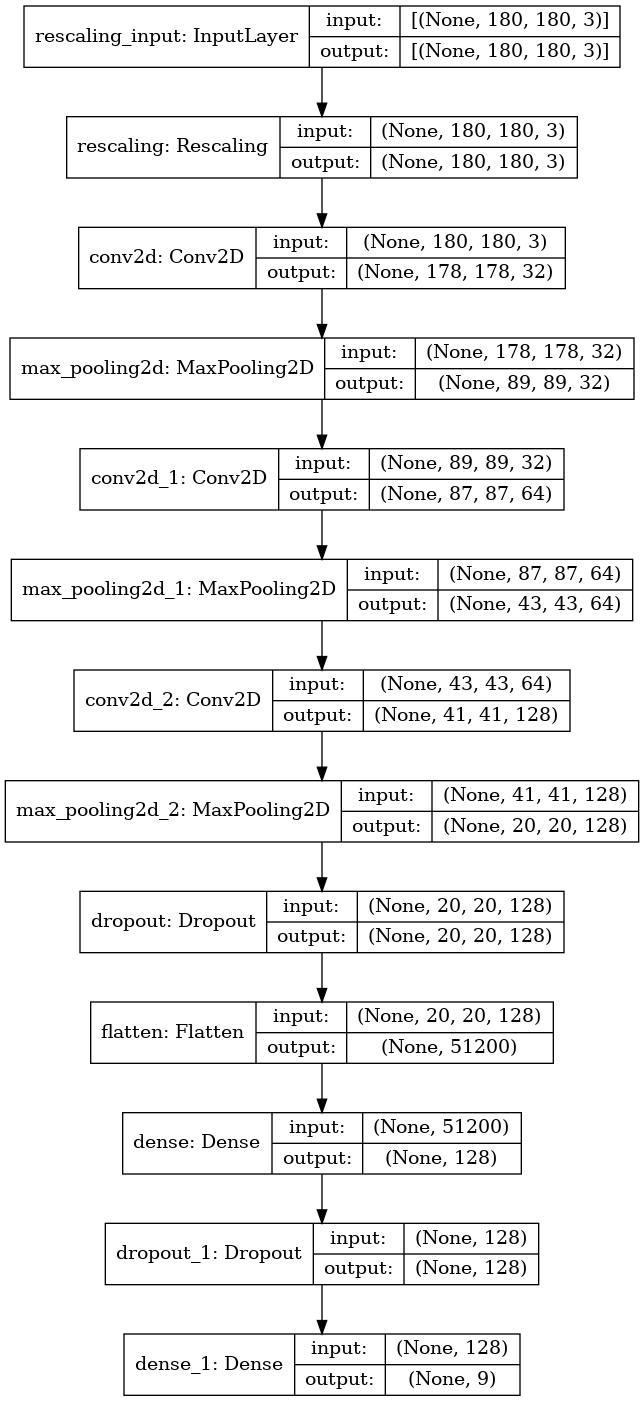

In [14]:
# vizualizing the model 
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# #ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
# #so the model or weights can be loaded later to continue the training from the state saved.
# checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# #Stop training when a monitored metric has stopped improving.
# earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0

### Train the model

In [17]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2023-01-17 22:50:22.974469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-17 22:50:33.241893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 24 of 1000
2023-01-17 22:50:40.558881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2023-01-17 22:50:42.344004: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 38s 124ms/step - loss: 2.1693 - accuracy: 0.2366 - val_loss: 1.8195 - val_accuracy: 0.3266
Epoch 2/30
56/56 [==============================] - 2s 34ms/step - loss: 1.8060 - accuracy: 0.3164 - val_loss: 1.6816 - val_accuracy: 0.4139
Epoch 3/30
56/56 [==============================] - 2s 33ms/step - loss: 1.6714 - accuracy: 0.4035 - val_loss: 1.5795 - val_accuracy: 0.4564
Epoch 4/30
56/56 [==============================] - 2s 33ms/step - loss: 1.6397 - accuracy: 0.4163 - val_loss: 1.6337 - val_accuracy: 0.4340
Epoch 5/30
56/56 [==============================] - 2s 35ms/step - loss: 1.5783 - accuracy: 0.4319 - val_loss: 1.4904 - val_accuracy: 0.5011
Epoch 6/30
56/56 [==============================] - 2s 33ms/step - loss: 1.4736 - accuracy: 0.4844 - val_loss: 1.4637 - val_accuracy: 0.5190
Epoch 7/30
56/56 [==============================] - 2s 33ms/step - loss: 1.4565 - accuracy: 0.4955 - val_loss: 1.4416 - val_accuracy: 0.5101
Epoch 8/30
56/56 [====

### Visualizing training results

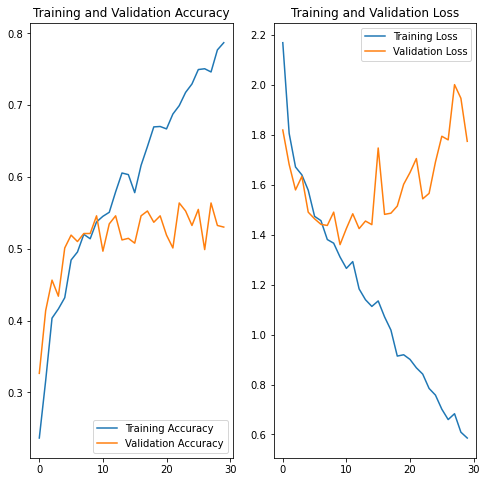

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### Findings on the first base model
- The model is overfitting because there is a big difference in the train and validation accuracy.
- The accuracy is around 75 to 79%

### Write your findings here

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

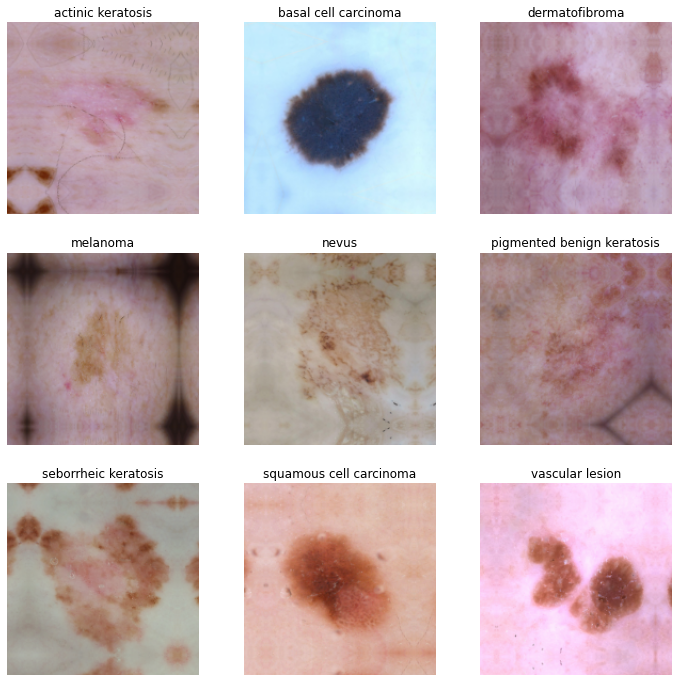

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here

def create_augmentation_model(data_augmentation):
    # Initilize a Sequential model object
    model = Sequential([data_augmentation])

    #Normalize the pixel values between (0,1)
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

    #First Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    #Second Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Third Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    #Fourth Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Fivth Convolution layer
    model.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Dropout layer with 50% of the units to drop
    model.add(layers.Dropout(0.25))

    #Flatten layer
    model.add(layers.Flatten())

    #Dense layer
    model.add(layers.Dense(512, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))
    
    #Dense layer
    model.add(layers.Dense(256, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))
    
    #Dense layer
    model.add(layers.Dense(128, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))

    #Dense layer with softmax activation function
    model.add(layers.Dense(len(class_names), activation="softmax"))
    
    return model

model = create_augmentation_model(data_augmentation)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 64)       

### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
## your training code

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 3s 34ms/step - loss: 2.0841 - accuracy: 0.1897 - val_loss: 2.0301 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 2s 30ms/step - loss: 2.0342 - accuracy: 0.1936 - val_loss: 1.9551 - val_accuracy: 0.1924
Epoch 3/30
56/56 [==============================] - 2s 29ms/step - loss: 1.9318 - accuracy: 0.2679 - val_loss: 1.8484 - val_accuracy: 0.2931
Epoch 4/30
56/56 [==============================] - 2s 29ms/step - loss: 1.8778 - accuracy: 0.2796 - val_loss: 1.8714 - val_accuracy: 0.3378
Epoch 5/30
56/56 [==============================] - 2s 30ms/step - loss: 1.7605 - accuracy: 0.3220 - val_loss: 1.6477 - val_accuracy: 0.3803
Epoch 6/30
56/56 [==============================] - 2s 29ms/step - loss: 1.7138 - accuracy: 0.3644 - val_loss: 1.6529 - val_accuracy: 0.3579
Epoch 7/30
56/56 [==============================] - 2s 29ms/step - loss: 1.6812 - accuracy: 0.3750 - val_loss: 1.6427 - val_accuracy: 0.4049
Epoch 8/30
56

### Visualizing the results

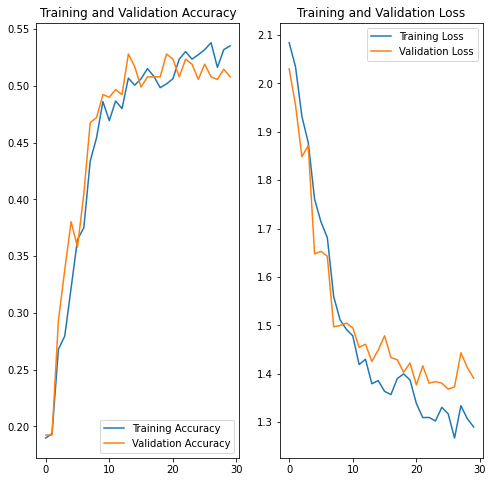

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Findings from Second model
- Clearly the problem of overfitting has been solved with data augmentation.
- There is no improvement in accuracy.
- Model is underfitting and increasing the number of epochs might improve the accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.

def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,462
1,melanoma,438
2,vascular lesion,139
3,actinic keratosis,114
4,squamous cell carcinoma,181
5,basal cell carcinoma,376
6,seborrheic keratosis,77
7,dermatofibroma,95
8,nevus,357


In [26]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list[:5]

['/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0028100.jpg',
 '/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0027960.jpg',
 '/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025454.jpg',
 '/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025876.jpg',
 '/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025575.jpg']

In [27]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list[:5]

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis']

In [28]:
original_df = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(original_df.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/kaggle/input/upgard-melanoma-detection/Skin c...,pigmented benign keratosis
1,/kaggle/input/upgard-melanoma-detection/Skin c...,pigmented benign keratosis
2,/kaggle/input/upgard-melanoma-detection/Skin c...,pigmented benign keratosis
3,/kaggle/input/upgard-melanoma-detection/Skin c...,pigmented benign keratosis
4,/kaggle/input/upgard-melanoma-detection/Skin c...,pigmented benign keratosis
...,...,...
2234,/kaggle/input/upgard-melanoma-detection/Skin c...,nevus
2235,/kaggle/input/upgard-melanoma-detection/Skin c...,nevus
2236,/kaggle/input/upgard-melanoma-detection/Skin c...,nevus
2237,/kaggle/input/upgard-melanoma-detection/Skin c...,nevus


<AxesSubplot:xlabel='No. of Image', ylabel='Class'>

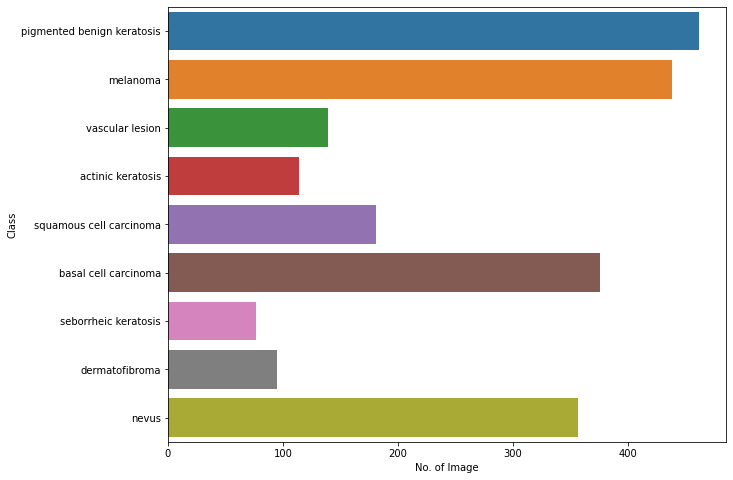

In [29]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 

#### 1. Which class has the least number of samples?
- **seborrheic keratosis** has least number of samples

#### 2. Which classes dominate the data in terms proportionate number of samples?
- **pigmented benign keratosis** and **melanoma** classes dominate the data in terms proportionate number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset= os.path.join(data_dir, "Train")
path_to_output_dataset = "/kaggle/working/balanced_data"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i),output_directory=os.path.join(path_to_output_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/balanced_data/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F24A8FD9E50>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/balanced_data/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F24A8ED5510>: 100%|██████████| 500/500 [00:18<00:00, 27.70 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/balanced_data/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F24A8F0F3D0>: 100%|██████████| 500/500 [00:17<00:00, 28.07 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/balanced_data/melanoma.

Processing <PIL.Image.Image image mode=RGB size=959x638 at 0x7F24A8F792D0>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/balanced_data/nevus.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F24A8F3A0D0>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/balanced_data/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F24987EE050>: 100%|██████████| 500/500 [00:18<00:00, 26.94 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/balanced_data/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F24A8FCF8D0>: 100%|██████████| 500/500 [00:44<00:00, 11.27 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/balanced_data/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F24A8F06210>: 100%|██████████| 500/500 [00:17<00:00, 28.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/balanced_data/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F24A8FE1B10>: 100%|██████████| 500/500 [00:17<00:00, 27.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
data_dir_train_balanced = pathlib.Path(path_to_output_dataset)
image_count_train = len(list(data_dir_train_balanced.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
path_list_new = [x for x in glob(os.path.join(data_dir_train_balanced, '*', '*.jpg'))]
path_list[:5]

['/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0028100.jpg',
 '/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0027960.jpg',
 '/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025454.jpg',
 '/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025876.jpg',
 '/kaggle/input/upgard-melanoma-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025575.jpg']

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train_balanced, '*', '*.jpg'))]
lesion_list_new[:5]

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion']

In [36]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
data_dir_train=os.path.join(data_dir_train_balanced)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [42]:
## your code goes here

def create_balanced_dataset_model():
    # Initilize a Sequential model object
    model = Sequential()

    #Normalize the pixel values between (0,1)
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

    #First Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    
    #Second Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    #Third Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    
    #Fourth Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    #Fivth Convolution layer
    model.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    #Dropout layer with 50% of the units to drop
    model.add(layers.Dropout(0.25))

    #Flatten layer
    model.add(layers.Flatten())

    #Dense layer
    model.add(layers.Dense(512, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))
    
    #Dense layer
    model.add(layers.Dense(256, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))
    
    #Dense layer
    model.add(layers.Dense(128, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))

    #Dense layer with softmax activation function
    model.add(layers.Dense(len(class_names), activation="softmax"))
    
    return model

model = create_balanced_dataset_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 89, 89, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 43, 43, 32)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## Your code goes here
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [44]:
epochs = 30
## Your code goes here, use 50 epochs.
# your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 29s 159ms/step - loss: 1.8350 - accuracy: 0.3316 - val_loss: 2.8017 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 27s 154ms/step - loss: 1.5238 - accuracy: 0.4254 - val_loss: 3.3268 - val_accuracy: 0.1195
Epoch 3/30
169/169 [==============================] - 27s 152ms/step - loss: 1.3865 - accuracy: 0.4757 - val_loss: 1.7207 - val_accuracy: 0.3608
Epoch 4/30
169/169 [==============================] - 26s 150ms/step - loss: 1.2797 - accuracy: 0.5200 - val_loss: 1.4023 - val_accuracy: 0.5004
Epoch 5/30
169/169 [==============================] - 26s 148ms/step - loss: 1.1486 - accuracy: 0.5744 - val_loss: 1.3367 - val_accuracy: 0.4974
Epoch 6/30
169/169 [==============================] - 26s 152ms/step - loss: 1.0400 - accuracy: 0.6113 - val_loss: 1.3546 - val_accuracy: 0.5486
Epoch 7/30
169/169 [==============================] - 26s 150ms/step - loss: 0.9142 - accuracy: 0.6619 - val_loss: 1.2468 - val_ac

#### **Todo:**  Visualize the model results

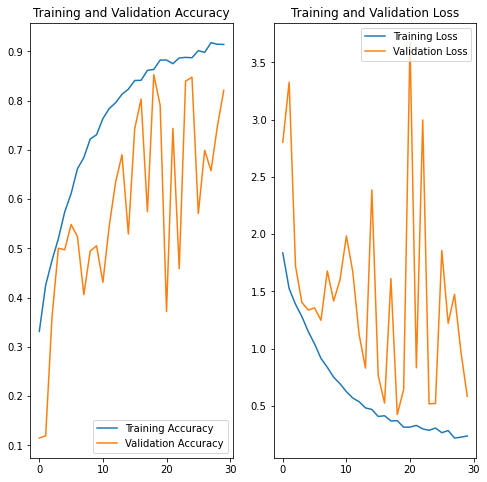

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Accuracy has increased with rebalancing the data & using the batchNormalization.
- Model is overfitting
- Class rebalanced helped to improve the accuracy but it did not help in handling overfitting